In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd 'drive/MyDrive/Colab Notebooks/BMI-Decoding'

/content/drive/MyDrive/Colab Notebooks/BMI-Decoding


In [ ]:
# import packages
import h5py
import numpy as np
from functions.preprocess import input_shaping, split_index
from functions.decoders import lstm_decoder
from functions.metrics import compute_rmse, compute_pearson
import matplotlib.pyplot as plt
import seaborn as sns
import time as timer
from tensorflow import random

In [ ]:
seed = 2020 # random seed for reproducibility

print ("Starting simulation")
run_start = timer.time()

feature_list = ['sua_rate','mua_rate']
feature = feature_list[1] # select which spike feature: SUA=0, MUA=1

# specify filename to be processed (choose from the list available at https://zenodo.org/record/583331)
file_name = 'indy_20160915_01'          # file name
kinematic_folder = 'kinematic_data/'    # kinematic data folder
feature_folder = 'spike_data/features/' # spike features folder
result_folder = 'results/'              # results folder

Starting simulation


In [ ]:
wdw_time = 0.256 # window size in second
lag = -32 # lag between kinematic and feature data (minus indicate feature lagging behaind kinematic)
delta_time = 0.004 # sampling interval in second
wdw_samp = int(round(wdw_time/delta_time))
ol_samp = wdw_samp-1

## Importing data to be processed

In [ ]:
# open spike features from hdf5 file
feature_file = feature_folder+file_name+'_spike_features_'+str(int(wdw_time*1e3))+'ms.h5'
print ("Loading input features from file: "+feature_file)
with h5py.File(feature_file,'r') as f:
    input_feature = f[feature].value

Loading input features from file: spike_data/features/indy_20160915_01_spike_features_256ms.h5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """


In [ ]:
# open kinematic data from hdf5 file
kinematic_file = kinematic_folder+file_name+'_kinematic_data.h5'
print ("Loading kinematic data from file: "+kinematic_file)
#fields: ['cursor_acc', 'cursor_pos', 'cursor_time', 'cursor_vel', 'target_pos']
with h5py.File(kinematic_file,'r') as f:
    cursor_vel = f['cursor_vel'].value # in mm/s

Loading kinematic data from file: kinematic_data/indy_20160915_01_kinematic_data.h5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


## Preprocessing the data to fit a model

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(input_feature)
y_mm = mm.fit_transform(cursor_vel)

In [ ]:
print(X_ss.shape, y_mm.shape)

(95262, 88) (95262, 2)


In [ ]:
#first 80,000 for training

X_train = X_ss[:80000, :]
X_test = X_ss[80000:, :]

y_train = y_mm[:80000, :]
y_test = y_mm[80000:, :] 

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (80000, 88) (80000, 2)
Testing Shape (15262, 88) (15262, 2)


## Adjusting the data for pytorch model

In [ ]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
#converting nparrays to tensors for pytorch

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))


In [ ]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([80000, 1, 88]) torch.Size([80000, 2])
Testing Shape torch.Size([15262, 1, 88]) torch.Size([15262, 2])


## Importing spytorch functions

In [ ]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 88*1
nb_hidden  = 100
nb_outputs = 2

time_step = 1e-3
nb_steps  = 100

batch_size = 256

dtype = torch.float
# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [ ]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [ ]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T
 

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, sample_size=nb_steps,overlap_units=1,shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(0,len(X)-sample_size,overlap_units)

#     # compute discrete firing times
#     tau_eff = 20e-3/time_step
#     firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int)
#     unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        
#         for batch_sample_i in range(batch_size):
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        
        X_batch = np.zeros((batch_size,sample_size,X.shape[-1]))
        y_batch = np.zeros((batch_size,y.shape[-1]))
        for bc,idx in enumerate(batch_index):
            X_batch[bc,:,:] = X[idx:idx+sample_size,:,:].reshape((1,sample_size,X.shape[-1]))
            y_batch[bc, :] = y[idx+sample_size,:]
            
#         i = torch.LongTensor(coo).to(device)
#         v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.FloatTensor(X_batch).to(device)
        y_batch = torch.tensor(y_batch,device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [ ]:

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [ ]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []
    

    # Compute hidden layer activity
    for t in range(nb_steps):
        # if t%5==0:
        #     print(t/nb_steps, ' ', end='')
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t,:]
#         new_mem = (beta*mem +syn)*(1.0-rst)
        new_mem = beta*(mem - rst) + rst + (1 - beta)*syn

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn
    # print('')

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)
    
    # nn.Linear(mem_, 128)(mem_rec)

    # Readout layer - make into different module, and then make a new module that's a NN module
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = []
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    out_rec = out_rec.reshape(batch_size,-1)
    lin = nn.Linear(nb_outputs*nb_hidden, nb_outputs).to(device)
    out_rec = lin(out_rec)

    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [ ]:
def train(x_data, y_data, x_val, y_val, lr=2e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    linear_fn = nn.LogSoftmax(dim=1)
    # linear_fn = nn.Linear(2,2)
    loss_fn = nn.MSELoss()
    
    loss_hist = []
    loss_hist_val = []
    for e in range(nb_epochs):
        local_loss = []
        local_val_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            # output,_ = run_snn(x_local.to_dense()) #use when access to gpu is available
            output,_ = run_snn(x_local)
            # velocity_out,_=torch.max(output,1)
            # velocity_out = linear_fn(m)
            loss_train = loss_fn(output.float(), y_local.float())
            


            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            local_loss.append(loss_train.item())

        for x_local, y_local in sparse_data_generator(x_val, y_val, batch_size, nb_steps, nb_inputs):
            val_out,_ = run_snn(x_local)
            loss_test = loss_fn(val_out.float(), y_local.float())
            
            local_val_loss.append(loss_test.item())
        
        mean_loss = np.mean(local_loss)
        mean_val_loss = np.mean(local_val_loss)

        print("Epoch %i: loss=%.5f  validation loss=%.5f"%(e+1,mean_loss,mean_val_loss))

        loss_hist.append(mean_loss)
        loss_hist_val.append(mean_val_loss)
        
    return loss_hist, loss_hist_val

In [ ]:
import gc
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing


In [ ]:
loss_hist, val_loss = train(X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors, lr=2e-4, nb_epochs=25)

Epoch 1: loss=24.63498  validation loss=14.96465
Epoch 2: loss=8.72444  validation loss=9.87410
Epoch 3: loss=5.42216  validation loss=8.33967
Epoch 4: loss=3.63739  validation loss=6.17869
Epoch 5: loss=2.67509  validation loss=4.68957
Epoch 6: loss=2.06517  validation loss=4.41275
Epoch 7: loss=1.55967  validation loss=3.10977
Epoch 8: loss=1.26829  validation loss=2.94770
Epoch 9: loss=1.03137  validation loss=2.27816
Epoch 10: loss=0.93064  validation loss=1.77106
Epoch 11: loss=0.75247  validation loss=1.62590
Epoch 12: loss=0.67843  validation loss=1.35181
Epoch 13: loss=0.59177  validation loss=1.06575
Epoch 14: loss=0.54389  validation loss=0.94255
Epoch 15: loss=0.49318  validation loss=0.90159
Epoch 16: loss=0.48284  validation loss=0.87529
Epoch 17: loss=0.43581  validation loss=0.72800
Epoch 18: loss=0.43696  validation loss=0.61677
Epoch 19: loss=0.40172  validation loss=0.59288
Epoch 20: loss=0.37938  validation loss=0.50600
Epoch 21: loss=0.38923  validation loss=0.48912

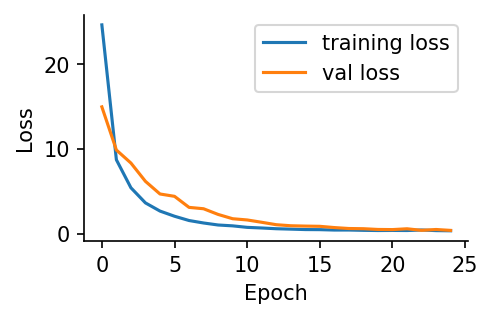

In [ ]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.plot(val_loss)
plt.legend(['training loss', 'val loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()